In [1]:
# %%HTML
# <script src="require.js"></script>

In [14]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [15]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

# Employee Attrition Analysis and Prediction

Using Machine Learning to Flag Employees with risk of attrition and reduce turnover



# Introduction

The objective of this analysis is to develop a predictive model that can effectively identify employees at risk of leaving the organization. By leveraging historical employee data, including demographics, job characteristics, and performance indicators, this model aims to assist HR departments in implementing timely interventions to retain valuable talent and reduce turnover.

The dataset used is from:https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data which comprises of employee details on the company including age, marital status, etc. which will be discussed further on the notebook. 

# Highlights

1. **Key Features Identified**: The 'OverTime' attribute has been consistently highlighted as a significant predictor across various models..
2. **Model Performance**: The model metrics improved significantly after applying oversampling on the imbalanced class, 'attrition'. 
3. **Insights Gained**: F1 is the best measure for Attrition data set to optimize investment interventation.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

## Loading the Data and Preprocessing

In [17]:
data = pd.read_csv('Employee.csv')
data.drop(columns=['EmployeeCount','StandardHours','JobRole', 'Over18', 'EmployeeNumber'], inplace=True)
data.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


## Preprocessing

### Check for missing values

In [18]:
data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Looking at the data, it has no missing values.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobSatisfaction           1470 non-null   int64 
 14  MaritalStatus           

In [20]:
df = data.copy()

### Feature Engineering

Checking the unique values on each column with dtype object.

In [21]:

object_columns = df.select_dtypes(include=['object']).columns
unique_values = {}
for col in object_columns:
    unique_values[col] = df[col].unique()
unique_values_flat = [(col, val) for col, vals in unique_values.items() for val in vals]
unique_values_df = pd.DataFrame(unique_values_flat, columns=['Column Name', 'Unique Values'])
unique_values_df


,Column Name,Unique Values
0,Attrition,Yes
1,Attrition,No
2,BusinessTravel,Travel_Rarely
3,BusinessTravel,Travel_Frequently
4,BusinessTravel,Non-Travel
5,Department,Sales
6,Department,Research & Development
7,Department,Human Resources
8,EducationField,Life Sciences
9,EducationField,Other


### Handling Categorical Data

In [22]:

Attrition_mapping = {'Yes': 1, 'No': 0}
df['Attrition'] = df['Attrition'].replace(Attrition_mapping)

BusinessTravel_mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
df['BusinessTravel'] = df['BusinessTravel'].replace(BusinessTravel_mapping)

Gender_mapping = {'Male': 1, 'Female': 0}
df['Gender'] = df['Gender'].replace(Gender_mapping)

OverTime_mapping = {'Yes': 1, 'No': 0}
df['OverTime'] = df['OverTime'].replace(OverTime_mapping)


In [23]:
# One-hot encode the MaritalStatus, EducationField, and Department columns
df = pd.get_dummies(df, columns=['MaritalStatus', 'EducationField', 'Department'])

df


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus_Single,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Department_Human Resources,Department_Research & Development,Department_Sales
0,41,1,1,1102,1,2,2,0,94,3,...,True,False,True,False,False,False,False,False,False,True
1,49,0,2,279,8,1,3,1,61,2,...,False,False,True,False,False,False,False,False,True,False
2,37,1,1,1373,2,2,4,1,92,2,...,True,False,False,False,False,True,False,False,True,False
3,33,0,2,1392,3,4,4,0,56,3,...,False,False,True,False,False,False,False,False,True,False
4,27,0,1,591,2,1,1,1,40,3,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,2,884,23,2,3,1,41,4,...,False,False,False,False,True,False,False,False,True,False
1466,39,0,1,613,6,1,4,1,42,2,...,False,False,False,False,True,False,False,False,True,False
1467,27,0,1,155,4,3,2,1,87,4,...,False,False,True,False,False,False,False,False,True,False
1468,49,0,2,1023,2,3,4,1,63,2,...,False,False,False,False,True,False,False,False,False,True


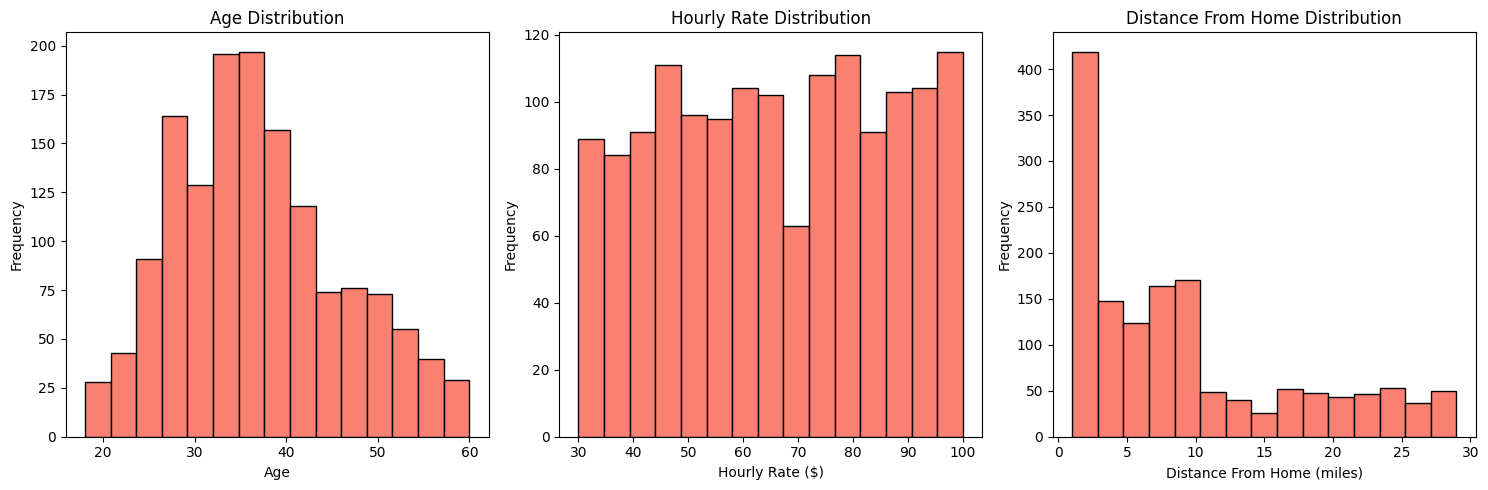

In [24]:

# Plotting histograms for 
plt.figure(figsize=(15, 5))

#Plot for 'Age'
plt.subplot(1, 3, 1)
plt.hist(df['Age'], bins=15, color='salmon', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot for 'HourlyRate'
plt.subplot(1, 3, 2)
plt.hist(df['HourlyRate'], bins=15, color='salmon', edgecolor='black')
plt.title('Hourly Rate Distribution')
plt.xlabel('Hourly Rate ($)')
plt.ylabel('Frequency')

# Plot for 'DistanceFromHome'
plt.subplot(1, 3, 3)
plt.hist(df['DistanceFromHome'], bins=15, color='salmon', edgecolor='black')
plt.title('Distance From Home Distribution')
plt.xlabel('Distance From Home (miles)')
plt.ylabel('Frequency')

# # Plot for 'PercentSalaryHike'
# plt.subplot(1, 3, 1)
# plt.hist(df['PercentSalaryHike'], bins=15, color='salmon', edgecolor='black')
# plt.title('Percent Salary Hike Distribution')
# plt.xlabel('Percent Salary Hike')
# plt.ylabel('Frequency')

# # Plot for 'NumCompaniesWorked'
# plt.subplot(1, 3, 2)
# plt.hist(df['NumCompaniesWorked'], bins=15, color='salmon', edgecolor='black')
# plt.title('Number of Companies Worked Distribution')
# plt.xlabel('Number of Companies Worked')
# plt.ylabel('Frequency')

# # Plot for 'EnvironmentSatisfaction'
# plt.subplot(1, 3, 3)
# plt.hist(df['EnvironmentSatisfaction'], bins=15, color='salmon', edgecolor='black')
# plt.title('Environment Satisfaction Distribution')
# plt.xlabel('Environment Satisfaction')
# plt.ylabel('Frequency')



# Show the plot
plt.tight_layout()
plt.show()


In [26]:
print(df['Attrition'].unique())

[1 0]


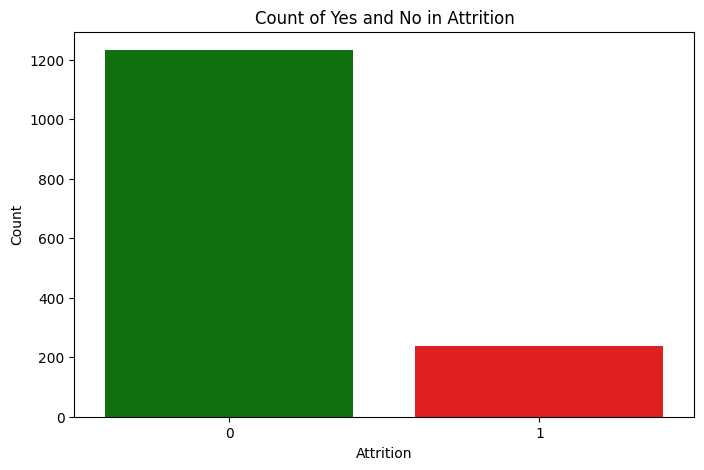

In [27]:
palette = {"1": "red", "0": "green"}  # Adjust keys to match the actual numeric values in 'Attrition'

plt.figure(figsize=(8, 5))
sns.countplot(x='Attrition', data=df, palette=palette)
plt.title('Count of Yes and No in Attrition')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

In [28]:
attrition_counts = df['Attrition'].value_counts()
attrition_counts

Attrition
0    1233
1     237
Name: count, dtype: int64

As shown on the figure, it is evident that the dataset is imbalanced.

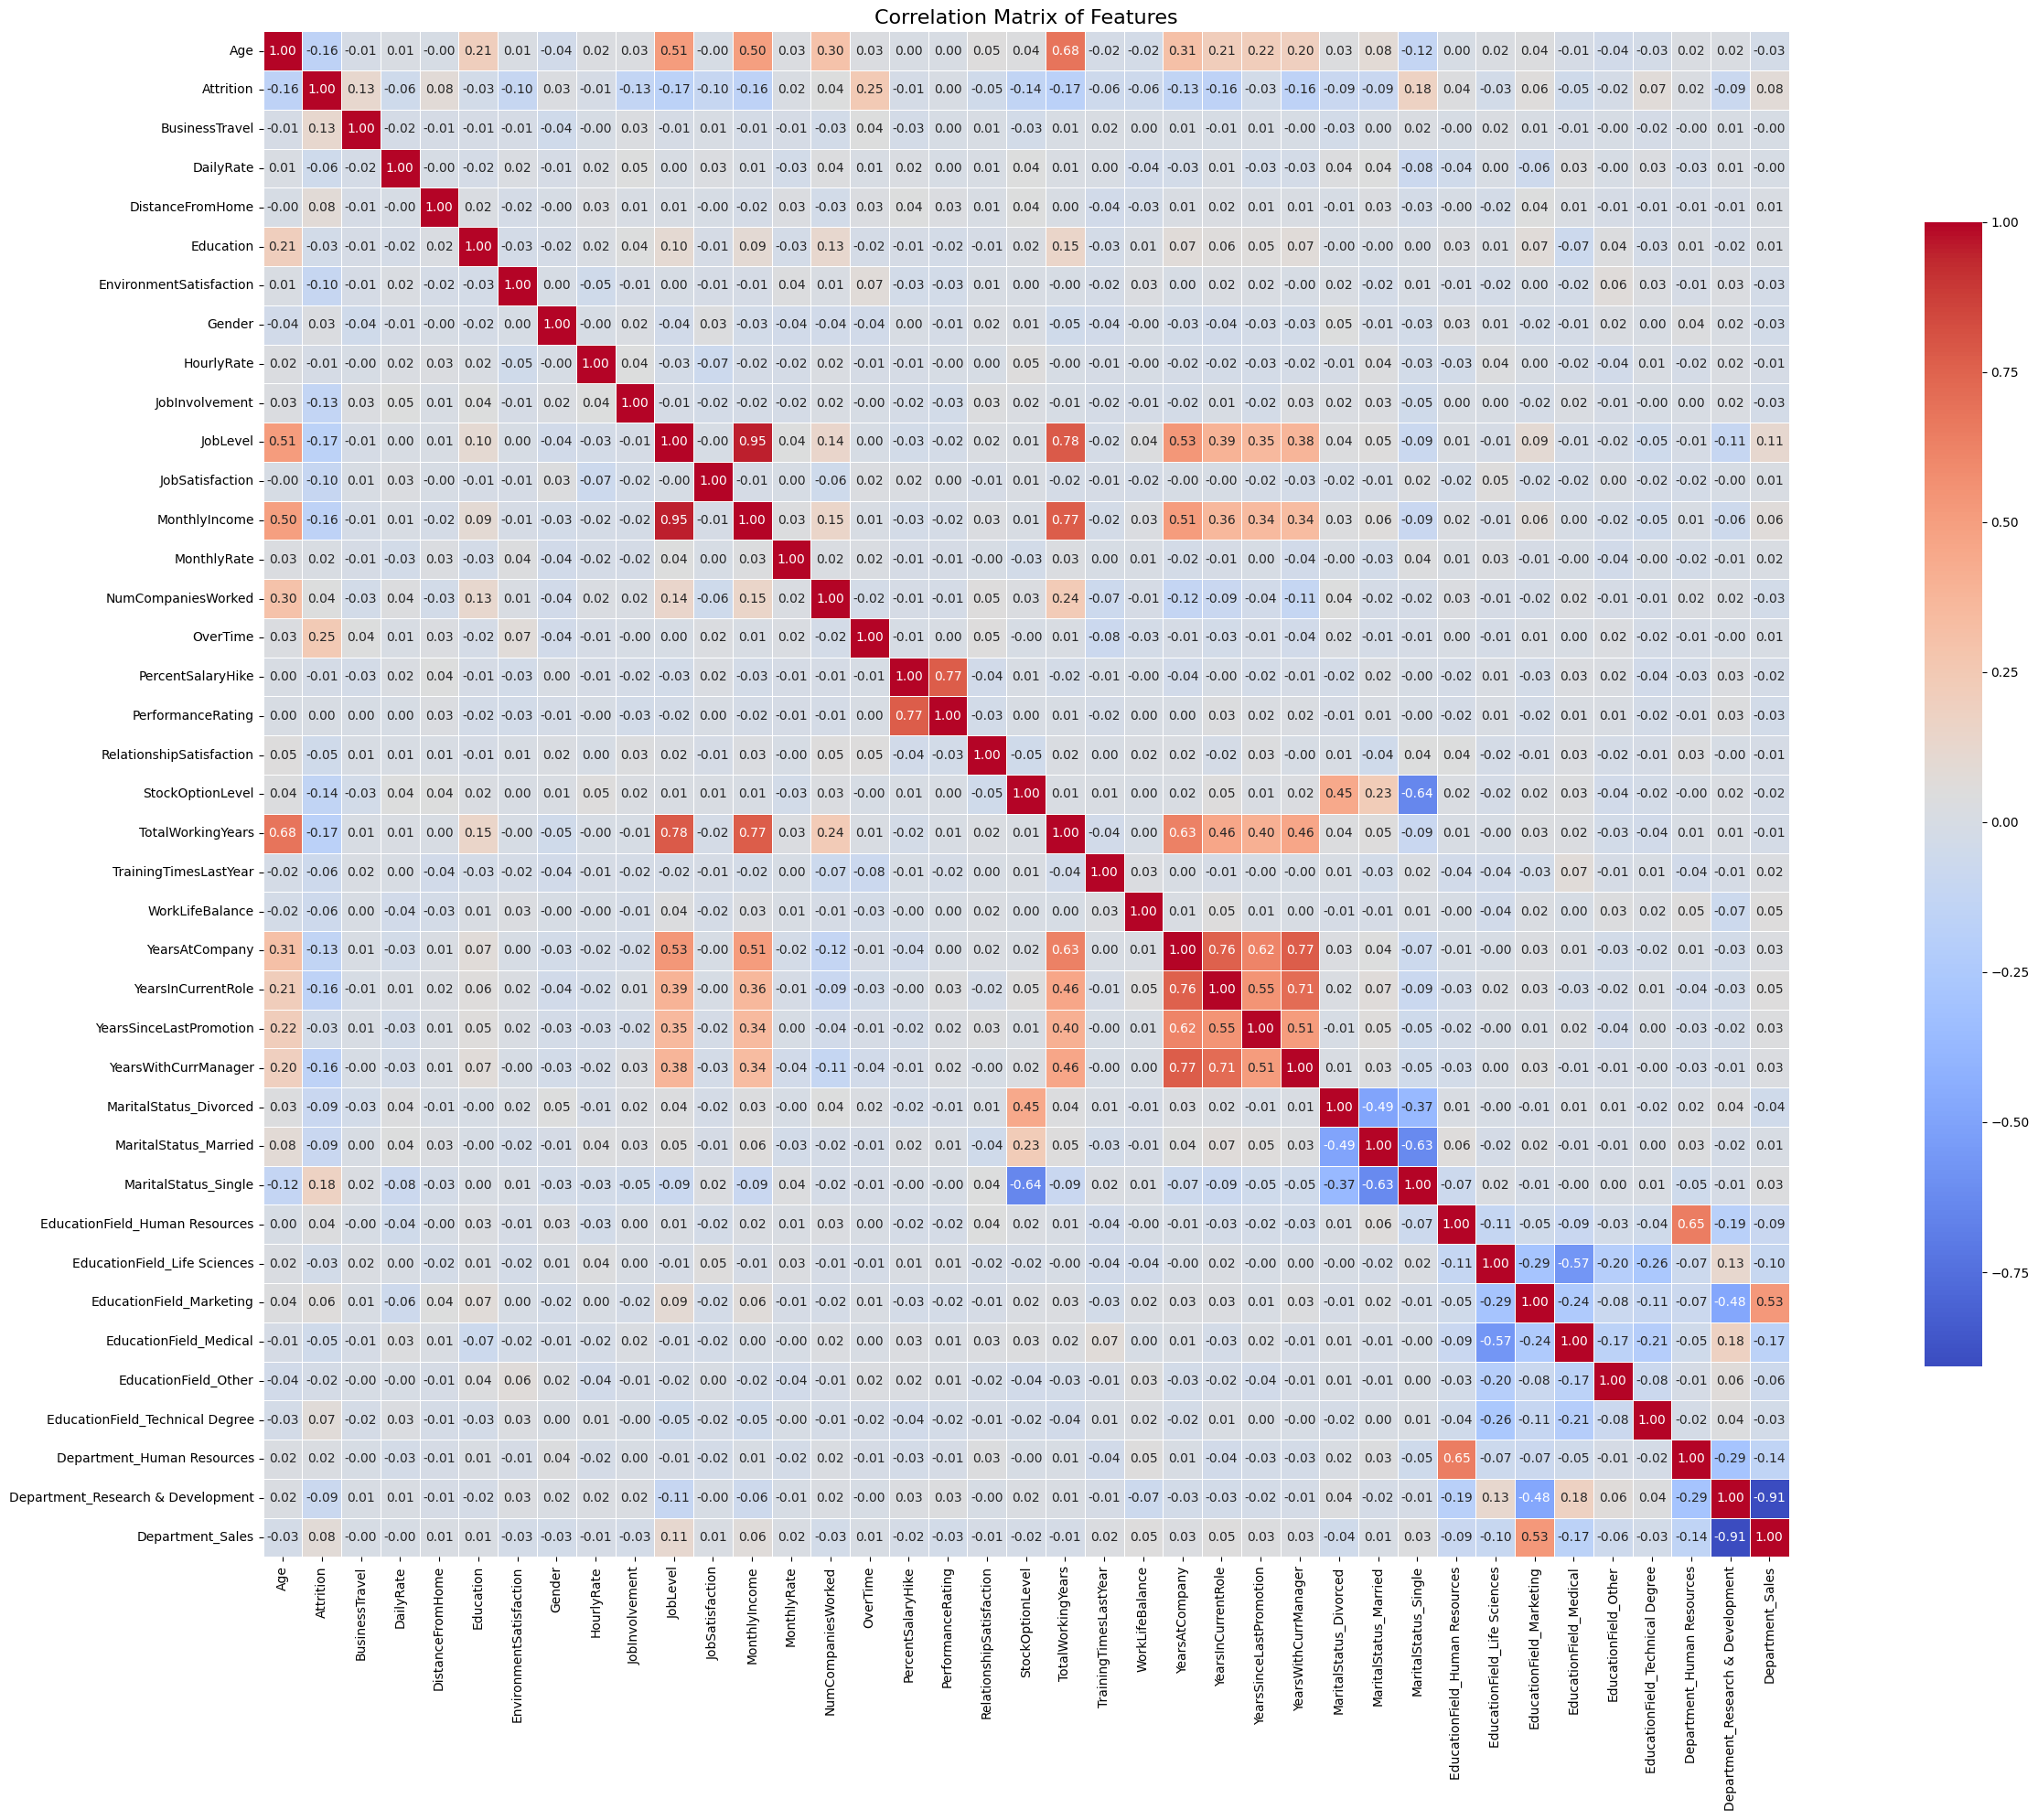

In [29]:
correlation_matrix = df.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, 
            cbar_kws={"shrink": .75}, linewidths=.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.show()

Seeing the correlation plot, there are observed high positive correlation on monthly income & joblevel, years at company & current manager, and some other naturally correlated variables. However, it can be observed the slightly strong negative correlation of MaritalStatus_Single on StockOptionlevel.

### Bringing features onto the same scale

In [30]:
df_cleaned = df.drop('Attrition', axis=1)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

# Fit the scaler to the data and transform
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
df_scaled

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,MaritalStatus_Single,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Department_Human Resources,Department_Research & Development,Department_Sales
0,0.446350,-0.162399,0.742527,-1.010909,-0.891688,-0.660531,-1.224745,1.383138,0.379672,-0.057788,...,1.458650,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.211604,-1.374051,1.515244
1,1.322365,1.717339,-1.297775,-0.147150,-1.868426,0.254625,0.816497,-0.240677,-1.026167,-0.057788,...,-0.685565,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
2,0.008343,-0.162399,1.414363,-0.887515,-0.891688,1.169781,0.816497,1.284725,-1.026167,-0.961486,...,1.458650,-0.136788,-0.837490,-0.348255,-0.679141,4.114223,-0.314093,-0.211604,0.727775,-0.659960
3,-0.429664,1.717339,1.461466,-0.764121,1.061787,1.169781,-1.224745,-0.486709,0.379672,-0.961486,...,-0.685565,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
4,-1.086676,-0.162399,-0.524295,-0.887515,-1.868426,-1.575686,0.816497,-1.274014,0.379672,-0.961486,...,-0.685565,-0.136788,-0.837490,-0.348255,1.472448,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,1.717339,0.202082,1.703764,-0.891688,0.254625,0.816497,-1.224807,1.785511,-0.057788,...,-0.685565,-0.136788,-0.837490,-0.348255,1.472448,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
1466,0.227347,-0.162399,-0.469754,-0.393938,-1.868426,1.169781,0.816497,-1.175601,-1.026167,0.845911,...,-0.685565,-0.136788,-0.837490,-0.348255,1.472448,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
1467,-1.086676,-0.162399,-1.605183,-0.640727,0.085049,-0.660531,0.816497,1.038693,1.785511,-0.057788,...,-0.685565,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.211604,0.727775,-0.659960
1468,1.322365,1.717339,0.546677,-0.887515,0.085049,1.169781,0.816497,-0.142264,-1.026167,-0.057788,...,-0.685565,-0.136788,-0.837490,-0.348255,1.472448,-0.243059,-0.314093,-0.211604,-1.374051,1.515244


# Machine Learning models experimentation

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Number_trials=20

def train_knn(X, y):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        neighbors_settings = range(1,20)

        accuracy_scores_trial = []
        precision_scores_trial = []
        recall_scores_trial = []
        f1_scores_trial = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # acc_train.append(clf.score(X_train, y_train))
            # acc_test.append(clf.score(X_test, y_test))

            accuracy_scores_trial.append(accuracy_score(y_test, y_pred))
            precision_scores_trial.append(precision_score(y_test, y_pred))
            recall_scores_trial.append(recall_score(y_test, y_pred))
            f1_scores_trial.append(f1_score(y_test, y_pred))

        accuracy_scores.append(accuracy_scores_trial)
        precision_scores.append(precision_scores_trial)
        recall_scores.append(recall_scores_trial)
        f1_scores.append(f1_scores_trial)
        # score_train.append(acc_train)
        # score_test.append(acc_test)

    # Calculate mean scores over trials
    mean_accuracy = np.mean(accuracy_scores, axis=0)
    mean_precision = np.mean(precision_scores, axis=0)
    mean_recall = np.mean(recall_scores, axis=0)
    mean_f1 = np.mean(f1_scores, axis=0)

#     score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(mean_accuracy), 'N_Neighbor = {0}'.format(np.argmax(mean_accuracy) + 1),
                'N/A', np.amax(mean_precision), np.amax(mean_recall), np.amax(mean_f1), run_time]

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    score_train = []
    score_test = []
    weighted_coefs=[]

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=10000, dual=False).fit(X_train, y_train)
            if reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False , max_iter=10000).fit(X_train, y_train)


#             training_accuracy.append(lr.score(X_train, y_train))
#             test_accuracy.append(lr.score(X_test, y_test))
#             coefs=np.abs(lr.coef_).mean(axis=0)
#             weighted_coefs.append(coefs) #append all the computed coefficients per trial

            y_pred = lr.predict(X_test)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            coefs = np.abs(lr.coef_).mean(axis=0)
            weighted_coefs.append(coefs)


        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    print(mean_coefs)
    score = np.mean(score_test, axis=0)
    
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)

    #Plot the weight of the parameters
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title("Parameter Weights in Logistic ({0})")
    plt.show()

    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(score), 'C = {0}'.format(C[np.argmax(score)]),
                top_predictor, np.amax(mean_precision), np.amax(mean_recall), np.amax(mean_f1), run_time]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))

            y_pred = svc.predict(X_test)
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

            coefs=np.abs(svc.coef_).mean(axis=0)
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)


    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    score = np.mean(score_test, axis=0)

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)


    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = mean_coefs
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title("Parameter Weights in Linear SVM" "({0})")
    plt.show()
    
    
    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), 'C = {0}'.format(C[np.argmax(score)]),
                top_predictor, np.amax(mean_precision), np.amax(mean_recall), np.amax(mean_f1), run_time]

def train_RF(X, y, reg):
    max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = RandomForestClassifier(n_estimators=100, max_features=max_features_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            y_pred = svc.predict(X_test)

            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)


    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    score = np.mean(score_test, axis=0)

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    print(abs_mean_coefs)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title("Parameter Weights in RF")
    plt.show()
    
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), 'Max_features = {0}'.format(max_features_tuning[np.argmax(score)]),
                top_predictor, np.amax(mean_precision), np.amax(mean_recall), np.amax(mean_f1), run_time]

def train_GBM(X, y, reg):
    max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8]
    score_train = []
    score_test = []
    weighted_coefs = []

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = GradientBoostingClassifier(n_estimators=100,max_depth=3, max_features=max_features_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            y_pred = svc.predict(X_test)

            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)


    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    score = np.mean(score_test, axis=0)

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)



    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title("Parameter Weights in Gradient Boost")
    plt.show()
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), 'Max_features = {0}'.format(max_features_tuning[np.argmax(score)]),
                top_predictor, np.amax(mean_precision), np.amax(mean_recall), np.amax(mean_f1), run_time]



['kNN', np.float64(0.8429347826086955), 'N_Neighbor = 13', 'N/A', np.float64(0.9083333333333332), np.float64(0.2119551697613448), np.float64(0.24592150543332889), 9.56764817237854]
9.56764817237854 seconds
[0.25019763 0.40002231 0.08942227 0.28838015 0.03996082 0.37805787
 0.15763008 0.03597293 0.31149526 0.29366318 0.35738545 0.16936349
 0.03611453 0.36542645 0.68785994 0.09023462 0.06484032 0.20824218
 0.1023732  0.3207527  0.168504   0.21662941 0.36912417 0.41485773
 0.44714037 0.33782544 0.17844487 0.0914294  0.25680283 0.07704644
 0.05948447 0.07165791 0.09743975 0.04698056 0.17240965 0.03085976
 0.12999904 0.13392009]


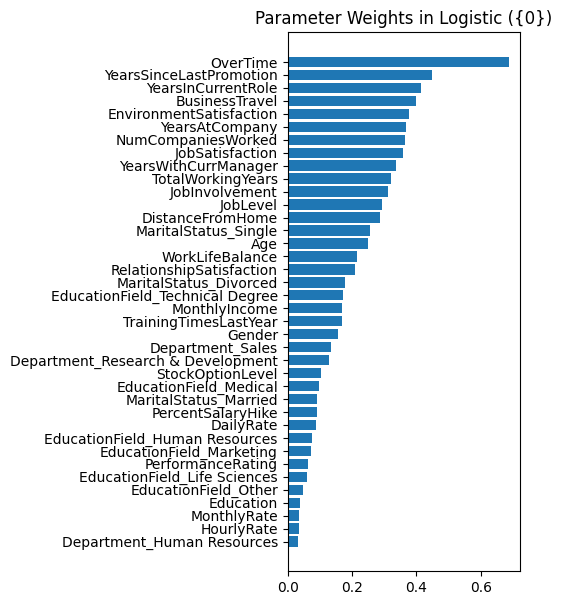

['Logistic (l2)', np.float64(0.8824728260869564), 'C = 0.2', 'OverTime', np.float64(0.6368148467223457), np.float64(0.3247061891970173), np.float64(0.4209378509978607), 3.7673001289367676]
3.7673001289367676 seconds
[0.23293874 0.37082352 0.0773108  0.26423964 0.03127956 0.3505388
 0.14099865 0.02799677 0.28990505 0.26941408 0.33102522 0.14011397
 0.02751541 0.33439582 0.64474082 0.06918675 0.04740525 0.1880857
 0.08742109 0.28833814 0.15017746 0.19632356 0.31190605 0.37840693
 0.41620863 0.2988215  0.10968417 0.02417958 0.2959077  0.06983449
 0.03215673 0.0749242  0.0670966  0.03068571 0.16784319 0.01021835
 0.12930342 0.11004884]


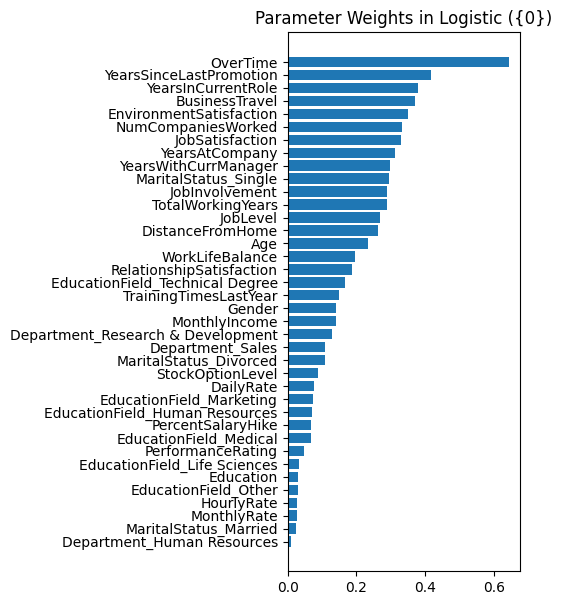

['Logistic (l1)', np.float64(0.8819293478260869), 'C = 0.4', 'OverTime', np.float64(0.5941809887988385), np.float64(0.3088141286158622), np.float64(0.4022824800956043), 5.812258720397949]
5.812258720397949 seconds


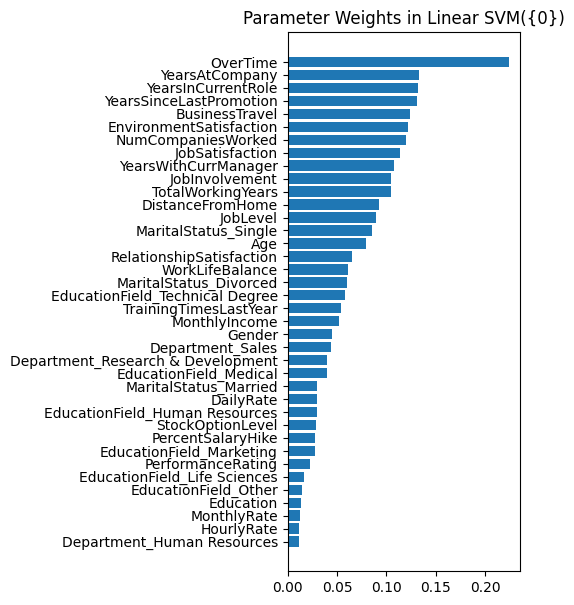

['Linear SVM (l2)', np.float64(0.8807065217391303), 'C = 0.01', 'OverTime', np.float64(0.7718034769690963), np.float64(0.36550387522468714), np.float64(0.48593187433644536), 3.2546682357788086]
3.2546682357788086 seconds


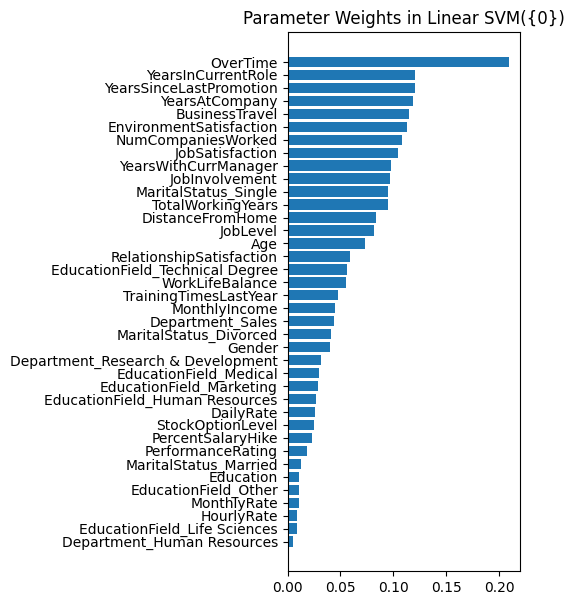

['Linear SVM (l1)', np.float64(0.8804347826086957), 'C = 0.2', 'OverTime', np.float64(0.6457283601677292), np.float64(0.28198370840161086), np.float64(0.386275023876106), 8.3495454788208]
8.3495454788208 seconds
[0.06590414 0.02008633 0.059183   0.05043957 0.01791116 0.03042142
 0.00755312 0.0477889  0.02562203 0.02043666 0.02584229 0.08493473
 0.05082961 0.0352947  0.0598632  0.03334213 0.00403617 0.0214387
 0.02810101 0.05743124 0.02545997 0.02599498 0.03944907 0.02283433
 0.02465493 0.02740934 0.00549438 0.00673612 0.01617549 0.00269369
 0.00618847 0.00808761 0.00743885 0.00325023 0.00851902 0.00249562
 0.00922081 0.01143696]


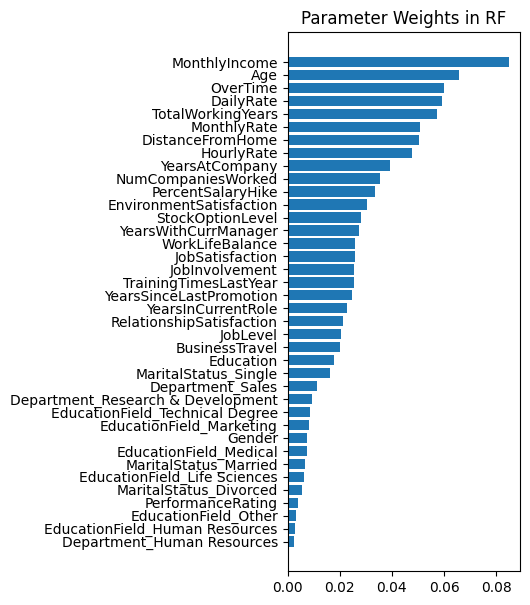

['Random Forest', np.float64(0.8577445652173911), 'Max_features = 0.5', 'MonthlyIncome', np.float64(0.7126822369290593), np.float64(0.1905945770125937), np.float64(0.2946707406684648), 44.27971172332764]
44.27971172332764 seconds


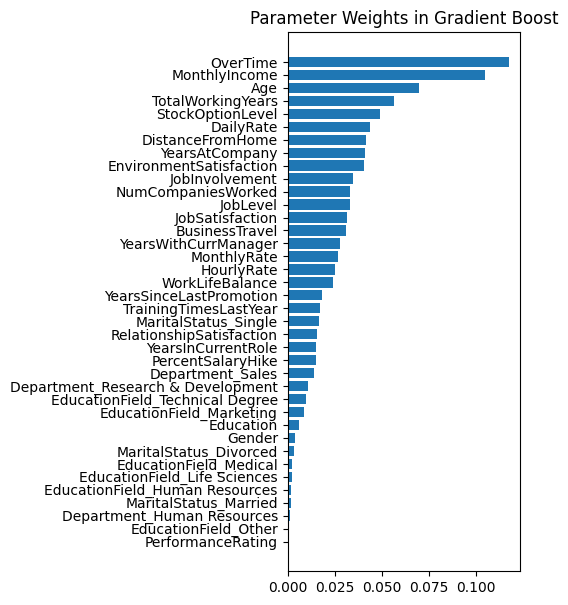

['Gradient Boosting Method', np.float64(0.8661684782608697), 'Max_features = 0.2', 'OverTime', np.float64(0.7040631920694718), np.float64(0.285389959900745), np.float64(0.40309805863642567), 23.628045558929443]
44.27971172332764 seconds


In [33]:
import time
X = df_scaled

y = df['Attrition']

start_time = time.time()
a = train_knn(X,y)
print(a)
print("%s seconds" % a[7])

start_time = time.time()
b = train_logistic(X,y,reg='l2')
print(b)
print("%s seconds" % b[7])

start_time = time.time()
c = train_logistic(X,y,reg='l1')
print(c)
print("%s seconds" % c[7])

start_time = time.time()
d = train_svm(X,y,reg='l2')
print(d)
print("%s seconds" % d[7])

start_time = time.time()
e = train_svm(X,y,reg='l1')
print(e)
print("%s seconds" % e[7])

start_time = time.time()
f = train_RF(X,y,reg='none')
print(f)
print("%s seconds" % f[7])

start_time = time.time()
g = train_GBM(X,y,reg='none')
print(g)
print("%s seconds" % f[7])


The result as a baseline without addressing imbalance class.

In [34]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Precision', 'Recall', 'F1', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g


df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Precision,Recall,F1,Run Time
0,kNN,0.842935,N_Neighbor = 13,N/A,0.908333,0.211955,0.245922,9.567648
1,Logistic (l2),0.882473,C = 0.2,OverTime,0.636815,0.324706,0.420938,3.767300
2,Logistic (l1),0.881929,C = 0.4,OverTime,0.594181,0.308814,0.402282,5.812259
3,Linear SVM (l2),0.880707,C = 0.01,OverTime,0.771803,0.365504,0.485932,3.254668
4,Linear SVM (l1),0.880435,C = 0.2,OverTime,0.645728,0.281984,0.386275,8.349545
5,Random Forest,0.857745,Max_features = 0.5,MonthlyIncome,0.712682,0.190595,0.294671,44.279712
6,Gradient Boosting Method,0.866168,Max_features = 0.2,OverTime,0.704063,0.285390,0.403098,23.628046
